In [2]:
import numpy as np
import matplotlib.pyplot as plt
from supervised_experiment import ActionNet, MLPNet, Encoder, ShapeDataset, SelectedDataset, encode
from vi_lie import rodrigues
import torch
from lie_learn.groups.SO3 import change_coordinates as SO3_coordinates

In [3]:
def plot_output(images, title=""):
    fig, ax = plt.subplots(1, 10, figsize=(20, 3))
    for ax, im in zip(ax.flatten(), images):
        ax.imshow(im.detach(), 'gray')
        ax.set_axis_off()
    fig.suptitle(title)
    fig.tight_layout()
    
def rotation_interpolation():
    start = torch.rand(3)[None] * 5
    end = torch.rand(3)[None] * 5
    t = torch.linspace(0, 1, 10)[:, None]
    x = (1-t) * start + end * t
    return rodrigues(x).detach()

def plot_reconstructions(versions, titles):
    n_versions = len(versions)
    n_images = len(versions[0])
    
    fig, ax = plt.subplots(n_images, n_versions, figsize=(10, 10))
    for i in range(n_images):
        for j in range(n_versions):
            ax[i, j].imshow(versions[j][i].detach(), 'gray')
            ax[i, j].set_axis_off()
            if i == 0:
                ax[i, j].set_title(titles[j])
    fig.tight_layout()

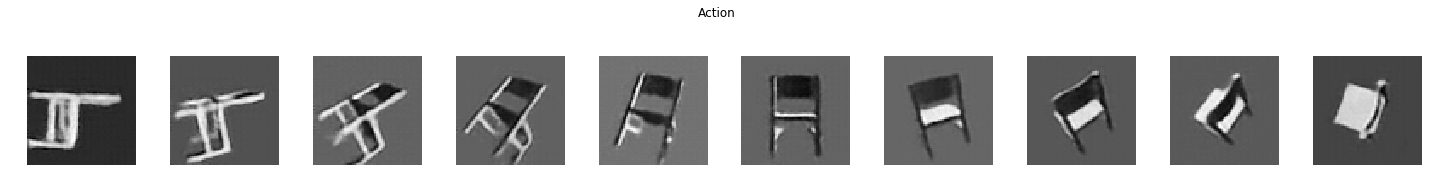

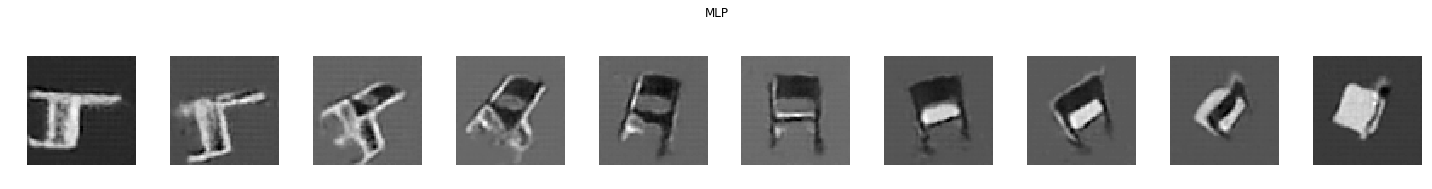

In [4]:
action_net = ActionNet(6)
action_net.load_state_dict(torch.load('supervised_outputs/action.pickle'))
mlp_net = MLPNet(6)
mlp_net.load_state_dict(torch.load('supervised_outputs/mlp.pickle'))

rot = rotation_interpolation()
action_outputs = action_net(rot)
mlp_outputs = mlp_net(rot)
    
plot_output(action_outputs, 'Action')
plot_output(mlp_outputs, 'MLP')

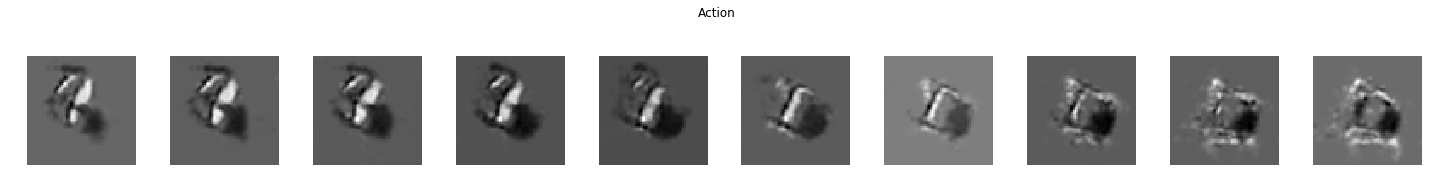

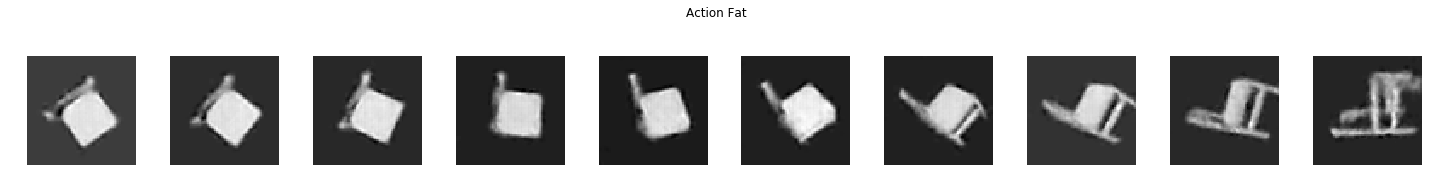

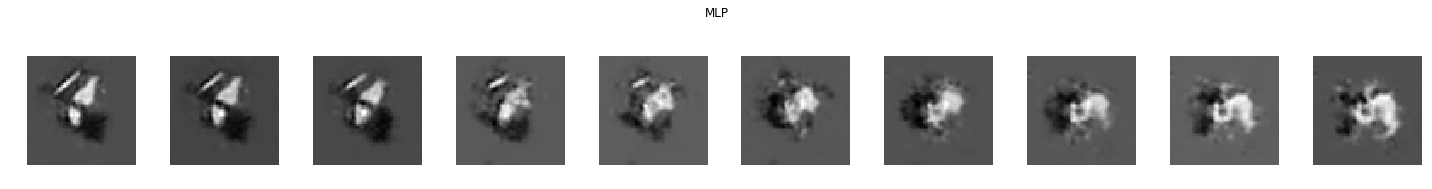

In [12]:
action_net = ActionNet(3)
action_net.load_state_dict(torch.load('ae_outputs/action_100.pickle'))
action_net_enc = Encoder()
state = torch.load('ae_outputs/action_100_enc.pickle')
for i in range(0, 10, 2):  # Trained without bias
    state['conv.%d.bias' % i] = torch.zeros(state['conv.%d.weight' % i].size(0))
action_net_enc.load_state_dict(state)

action_net_fat = ActionNet(8, deconv_hidden=200)
action_net_fat.load_state_dict(torch.load('ae_outputs/fat/action_100.pickle'))
action_net_enc_fat = Encoder()
state = torch.load('ae_outputs/fat/action_100_enc.pickle')
for i in range(0, 10, 2):  # Trained without bias
    state['conv.%d.bias' % i] = torch.zeros(state['conv.%d.weight' % i].size(0))
action_net_enc_fat.load_state_dict(state)

mlp_net = MLPNet(3)
mlp_net.load_state_dict(torch.load('ae_outputs/mlp_100.pickle'))
# mlp_net_enc = Encoder()
# mlp_net_enc.load_state_dict(torch.load('ae_outputs/mlp_100_enc.pickle'))

rot = rotation_interpolation()
action_outputs = action_net(rot)
action_fat_outputs = action_net_fat(rot)
mlp_outputs = mlp_net(rot)
    
plot_output(action_outputs, 'Action')
plot_output(action_fat_outputs, 'Action Fat')
plot_output(mlp_outputs, 'MLP')

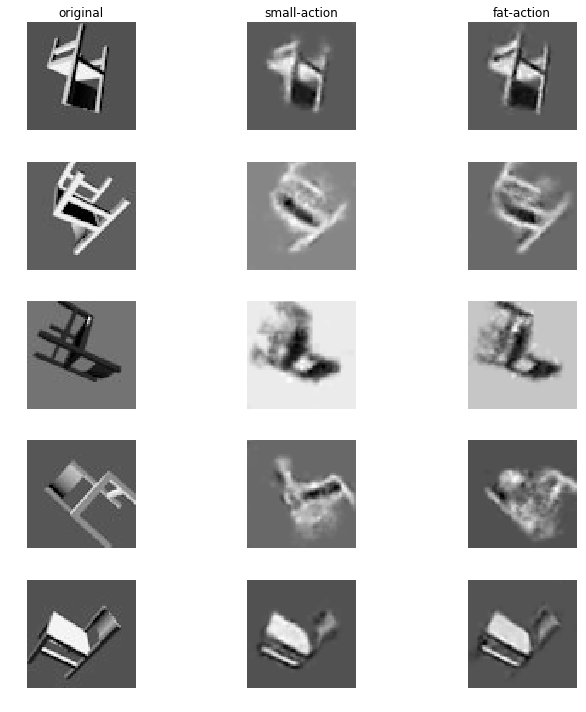

In [48]:
dataset = ShapeDataset('./shapes')
idxs = np.random.choice(len(dataset), size=5, replace=False)
images = torch.stack([dataset[i][1] for i in idxs], 0)
reconstructions = action_net(action_net_enc(images))
reconstructions_fat = action_net_fat(action_net_enc_fat(images))
    
plot_reconstructions([images, reconstructions, reconstructions_fat],
                     ['original', 'small-action', 'fat-action'])

In [ ]:
multi_dataset = SelectedDataset()

In [32]:
multi_action_dec = ActionNet(3, single_id=False)
multi_action_dec.load_state_dict(torch.load('multi_outputs/ae-action/action_3.pickle'))
multi_action_enc = Encoder(id_dims=10)
multi_action_enc.load_state_dict(torch.load('multi_outputs/ae-action/action_3_enc.pickle'))

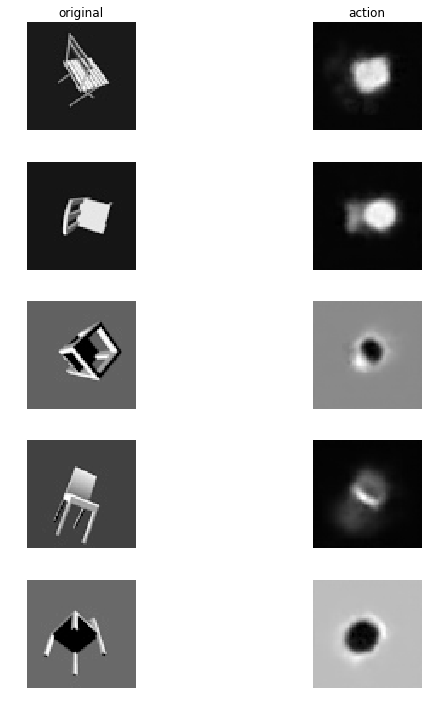

In [36]:
idxs = np.random.choice(len(multi_dataset), size=5, replace=False)
id_label, rot_label, img_label = zip(*[multi_dataset[i] for i in idxs])
id_label = torch.tensor(id_label, dtype=torch.long)
rot_label = torch.stack(rot_label, 0)
img_label = torch.stack(img_label, 0)

code = multi_action_enc(img_label)
reconstructions = multi_action_dec(*code)
    
plot_reconstructions([img_label, reconstructions],
                     ['original', 'action'])